<a href="https://colab.research.google.com/github/one-last-time/FTFL/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

In the real world, data rarely comes in a tidy form.
With this in mind, one of the more important steps in using machine learning in practice is *feature engineering*: that is, taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

In this section, we will cover a few common examples of feature engineering tasks: features for representing *categorical data*, features for representing *text*, and features for representing *images*.
Additionally, we will discuss *derived features* for increasing model complexity and *imputation* of missing data.
Often this process is known as *vectorization*, as it involves converting arbitrary data into well-behaved vectors.

## Categorical Features

One common type of non-numerical data is *categorical* data.
For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information.
For example, your data might look something like this:

In [ ]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

You might be tempted to encode this data with a straightforward numerical mapping:

In [ ]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

It turns out that this is not generally a useful approach in Scikit-Learn: the package's models make the fundamental assumption that numerical features reflect algebraic quantities.
Thus such a mapping would imply, for example, that *Queen Anne < Fremont < Wallingford*, or even that *Wallingford - Queen Anne = Fremont*, which (niche demographic jokes aside) does not make much sense.

In this case, one proven technique is to use *one-hot encoding*, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively.
When your data comes as a list of dictionaries, Scikit-Learn's ``DictVectorizer`` will do this for you:

In [ ]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]], dtype=int64)

Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood.
With these categorical features thus encoded, you can proceed as normal with fitting a Scikit-Learn model.

To see the meaning of each column, you can inspect the feature names:

In [ ]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

There is one clear disadvantage of this approach: if your category has many possible values, this can *greatly* increase the size of your dataset.
However, because the encoded data contains mostly zeros, a sparse output can be a very efficient solution:

In [ ]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

Many (though not yet all) of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models. ``sklearn.preprocessing.OneHotEncoder`` and ``sklearn.feature_extraction.FeatureHasher`` are two additional tools that Scikit-Learn includes to support this type of encoding.

In [ ]:
import pandas as pd
import numpy as np
import copy
%matplotlib inline


In [ ]:
df_flights = pd.read_csv('https://raw.githubusercontent.com/ismayc/pnwflights14/master/data/flights.csv')

df_flights.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2014,1,1,1.0,96.0,235.0,70.0,AS,N508AS,145,PDX,ANC,194.0,1542,0.0,1.0
1,2014,1,1,4.0,-6.0,738.0,-23.0,US,N195UW,1830,SEA,CLT,252.0,2279,0.0,4.0
2,2014,1,1,8.0,13.0,548.0,-4.0,UA,N37422,1609,PDX,IAH,201.0,1825,0.0,8.0
3,2014,1,1,28.0,-2.0,800.0,-23.0,US,N547UW,466,PDX,CLT,251.0,2282,0.0,28.0
4,2014,1,1,34.0,44.0,325.0,43.0,AS,N762AS,121,SEA,ANC,201.0,1448,0.0,34.0


In [ ]:
print(df_flights.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162049 entries, 0 to 162048
Data columns (total 16 columns):
year         162049 non-null int64
month        162049 non-null int64
day          162049 non-null int64
dep_time     161192 non-null float64
dep_delay    161192 non-null float64
arr_time     161061 non-null float64
arr_delay    160748 non-null float64
carrier      162049 non-null object
tailnum      161801 non-null object
flight       162049 non-null int64
origin       162049 non-null object
dest         162049 non-null object
air_time     160748 non-null float64
distance     162049 non-null int64
hour         161192 non-null float64
minute       161192 non-null float64
dtypes: float64(7), int64(5), object(4)
memory usage: 19.8+ MB
None


In [ ]:
## Filtering Categorical Data Out
cat_df_flights = df_flights.select_dtypes(include=['object']).copy()
cat_df_flights.head()


,carrier,tailnum,origin,dest
0,AS,N508AS,PDX,ANC
1,US,N195UW,SEA,CLT
2,UA,N37422,PDX,IAH
3,US,N547UW,PDX,CLT
4,AS,N762AS,SEA,ANC


In [ ]:
## Checking Null Values
print(cat_df_flights.isnull().values.sum())


248


In [ ]:
## Column Wise Distribution of Null Values
print(cat_df_flights.isnull().sum())

carrier      0
tailnum    248
origin       0
dest         0
dtype: int64


In [ ]:
cat_df_flights = cat_df_flights.fillna(cat_df_flights['tailnum']
                                       .value_counts().index[0])


Note the chaining of method .value_counts() in the code below. This returns the frequency distribution of each category in the feature, and then selecting the top category, which is the mode, with the .index attribute.

In [ ]:
cat_df_flights = cat_df_flights.fillna(cat_df_flights['tailnum'].value_counts().index[0])
print(cat_df_flights.isnull().values.sum())

0


In [ ]:
print(cat_df_flights['carrier'].value_counts())

AS    62460
WN    23355
OO    18710
DL    16716
UA    16671
AA     7586
US     5946
B6     3540
VX     3272
F9     2698
HA     1095
Name: carrier, dtype: int64


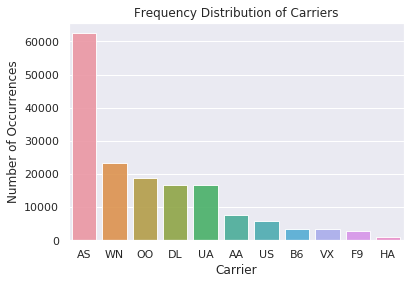

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
carrier_count = cat_df_flights['carrier'].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of Carriers')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Carrier', fontsize=12)
plt.show()

## Encoding Categorical Data


*   Replacing values
*   Encoding labels
*   One-Hot encoding
*   Binary encoding
*   Backward difference encoding
*   Miscellaneous features









In [ ]:
## Replacing Values
replace_map = {'carrier': {'AA': 1, 'AS': 2, 'B6': 3, 'DL': 4,
                                  'F9': 5, 'HA': 6, 'OO': 7 , 'UA': 8 , 'US': 9,'VX': 10,'WN': 11}}

Note that defining a mapping via a hard coded dictionary is easy when the number of categories is low, like in this case which is 11. You can achieve the same mapping with the help of dictionary comprehensions as shown below. This will be useful when the categories count is high and you don't want to type out each mapping. You will store the category names in a list called labels and then zip it to a seqeunce of numbers and iterate over it.

In [ ]:
labels = cat_df_flights['carrier'].astype('category').cat.categories.tolist()
replace_map_comp = {'carrier' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(replace_map_comp)

{'carrier': {'AA': 1, 'AS': 2, 'B6': 3, 'DL': 4, 'F9': 5, 'HA': 6, 'OO': 7, 'UA': 8, 'US': 9, 'VX': 10, 'WN': 11}}


In [ ]:
cat_df_flights_replace = cat_df_flights.copy()


In [ ]:
cat_df_flights_replace.replace(replace_map_comp, inplace=True)

print(cat_df_flights_replace.head())


   carrier tailnum origin dest
0        2  N508AS    PDX  ANC
1        9  N195UW    SEA  CLT
2        8  N37422    PDX  IAH
3        9  N547UW    PDX  CLT
4        2  N762AS    SEA  ANC


In [ ]:
print(cat_df_flights_replace['carrier'].dtypes)


int64


## Label Encoding

In [ ]:
cat_df_flights = df_flights.select_dtypes(include=['object']).copy()
cat_df_flights

,carrier,tailnum,origin,dest
0,AS,N508AS,PDX,ANC
1,US,N195UW,SEA,CLT
2,UA,N37422,PDX,IAH
3,US,N547UW,PDX,CLT
4,AS,N762AS,SEA,ANC
...,...,...,...,...
162044,UA,N477UA,PDX,IAH
162045,DL,N137DL,SEA,ATL
162046,AS,N530AS,SEA,SAN
162047,US,NaN,PDX,PHX


In [ ]:

cat_df_flights_lc = cat_df_flights
cat_df_flights_lc.head()

,carrier,tailnum,origin,dest
0,AS,N508AS,PDX,ANC
1,US,N195UW,SEA,CLT
2,UA,N37422,PDX,IAH
3,US,N547UW,PDX,CLT
4,AS,N762AS,SEA,ANC


In [ ]:
cat_df_flights_lc = cat_df_flights.copy()

cat_df_flights_lc['carrier'] = cat_df_flights_lc['carrier'].astype('category')
cat_df_flights_lc['origin'] = cat_df_flights_lc['origin'].astype('category')  

print(cat_df_flights_lc.dtypes)

carrier    category
tailnum      object
origin     category
dest         object
dtype: object


In [ ]:
cat_df_flights_lc['carrier'] = cat_df_flights_lc['carrier'].cat.codes


In [ ]:
cat_df_flights_lc.head() #alphabetically labeled from 0 to 10

,carrier,tailnum,origin,dest
0,1,N508AS,PDX,ANC
1,8,N195UW,SEA,CLT
2,7,N37422,PDX,IAH
3,8,N547UW,PDX,CLT
4,1,N762AS,SEA,ANC


In [ ]:
cat_df_flights_specific = cat_df_flights.copy()
cat_df_flights_specific['US_code'] = np.where(cat_df_flights_specific['carrier'].str.contains('US'), 1, 0)

cat_df_flights_specific.head()

,carrier,tailnum,origin,dest,US_code
0,AS,N508AS,PDX,ANC,0
1,US,N195UW,SEA,CLT,1
2,UA,N37422,PDX,IAH,0
3,US,N547UW,PDX,CLT,1
4,AS,N762AS,SEA,ANC,0


## One Hot Encoding

The basic strategy is to convert each category value into a new column and assign a 1 or 0 (True/False) value to the column. This has the benefit of not weighting a value improperly.



In [ ]:
cat_df_flights_onehot = cat_df_flights.copy()
cat_df_flights_onehot = pd.get_dummies(cat_df_flights_onehot, 
                    columns=['carrier'], prefix = ['carrier'])

print(cat_df_flights_onehot.head())

  tailnum origin dest  ...  carrier_US  carrier_VX  carrier_WN
0  N508AS    PDX  ANC  ...           0           0           0
1  N195UW    SEA  CLT  ...           1           0           0
2  N37422    PDX  IAH  ...           0           0           0
3  N547UW    PDX  CLT  ...           1           0           0
4  N762AS    SEA  ANC  ...           0           0           0

[5 rows x 14 columns]


## Binary Encoding

This technique is not as intuitive as the previous ones. In this technique, first the categories are encoded as ordinal, then those integers are converted into binary code, then the digits from that binary string are split into separate columns. This encodes the data in fewer dimensions than one-hot.

In [ ]:
pip install category_encoders

     |████████████████████████████████| 102kB 5.6MB/s 


In [ ]:
cat_df_flights_ce = cat_df_flights.copy()

import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['carrier'])
df_binary = encoder.fit_transform(cat_df_flights_ce)

df_binary.head()

,carrier_0,carrier_1,carrier_2,carrier_3,carrier_4,tailnum,origin,dest
0,0,0,0,0,1,N508AS,PDX,ANC
1,0,0,0,1,0,N195UW,SEA,CLT
2,0,0,0,1,1,N37422,PDX,IAH
3,0,0,0,1,0,N547UW,PDX,CLT
4,0,0,0,0,1,N762AS,SEA,ANC


## Backward Difference Encoding
This technique falls under the contrast coding system for categorical features. A feature of K categories, or levels, usually enters a regression as a sequence of K-1 dummy variables. In backward difference coding, the mean of the dependent variable for a level is compared with the mean of the dependent variable for the prior level. This type of coding may be useful for a nominal or an ordinal variable.

In [ ]:
encoder = ce.BackwardDifferenceEncoder(cols=['carrier'])
df_bd = encoder.fit_transform(cat_df_flights_ce)

df_bd.head()

,intercept,carrier_0,carrier_1,carrier_2,carrier_3,carrier_4,carrier_5,carrier_6,carrier_7,carrier_8,carrier_9,tailnum,origin,dest
0,1,-0.909091,-0.818182,-0.727273,-0.636364,-0.545455,-0.454545,-0.363636,-0.272727,-0.181818,-0.090909,N508AS,PDX,ANC
1,1,0.090909,-0.818182,-0.727273,-0.636364,-0.545455,-0.454545,-0.363636,-0.272727,-0.181818,-0.090909,N195UW,SEA,CLT
2,1,0.090909,0.181818,-0.727273,-0.636364,-0.545455,-0.454545,-0.363636,-0.272727,-0.181818,-0.090909,N37422,PDX,IAH
3,1,0.090909,-0.818182,-0.727273,-0.636364,-0.545455,-0.454545,-0.363636,-0.272727,-0.181818,-0.090909,N547UW,PDX,CLT
4,1,-0.909091,-0.818182,-0.727273,-0.636364,-0.545455,-0.454545,-0.363636,-0.272727,-0.181818,-0.090909,N762AS,SEA,ANC


[link text](https://)

## Text Features

Another common need in feature engineering is to convert text to a set of representative numerical values.
For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
One of the simplest methods of encoding data is by *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of three phrases:

In [ ]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

For a vectorization of this data based on word count, we could construct a column representing the word "problem," the word "evil," the word "horizon," and so on.
While doing this by hand would be possible, the tedium can be avoided by using Scikit-Learn's ``CountVectorizer``:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

The result is a sparse matrix recording the number of times each word appears; it is easier to inspect if we convert this to a ``DataFrame`` with labeled columns:

In [ ]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


There are some issues with this approach, however: the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms.
One approach to fix this is known as *term frequency-inverse document frequency* (*TF–IDF*) which weights the word counts by a measure of how often they appear in the documents.
The syntax for computing these features is similar to the previous example:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000




> TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).



> IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).



> Consider a document containing 100 words wherein the word cat appears 3 times. The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.








## Image Features

Another common need is to suitably encode *images* for machine learning analysis.
The simplest approach is what we used for the digits data in [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb): simply using the pixel values themselves.
But depending on the application, such approaches may not be optimal.

A comprehensive summary of feature extraction techniques for images is well beyond the scope of this section, but you can find excellent implementations of many of the standard approaches in the [Scikit-Image project](http://scikit-image.org).
For one example of using Scikit-Learn and Scikit-Image together, see [Feature Engineering: Working with Images](05.14-Image-Features.ipynb).

## Derived Features

Another useful type of feature is one that is mathematically derived from some input features.
We saw an example of this in [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) when we constructed *polynomial features* from our input data.
We saw that we could convert a linear regression into a polynomial regression not by changing the model, but by transforming the input!
This is sometimes known as *basis function regression*, and is explored further in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).

For example, this data clearly cannot be well described by a straight line:

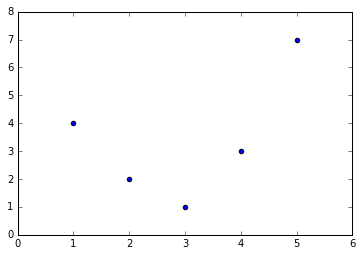

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

Still, we can fit a line to the data using ``LinearRegression`` and get the optimal result:

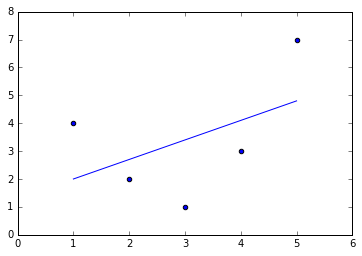

In [ ]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

It's clear that we need a more sophisticated model to describe the relationship between $x$ and $y$.

One approach to this is to transform the data, adding extra columns of features to drive more flexibility in the model.
For example, we can add polynomial features to the data this way:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[   1.    1.    1.]
 [   2.    4.    8.]
 [   3.    9.   27.]
 [   4.   16.   64.]
 [   5.   25.  125.]]


The derived feature matrix has one column representing $x$, and a second column representing $x^2$, and a third column representing $x^3$.
Computing a linear regression on this expanded input gives a much closer fit to our data:

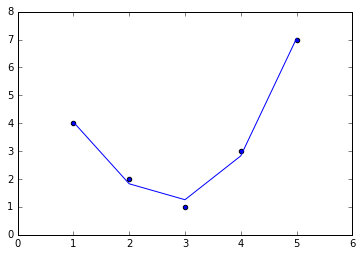

In [ ]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

This idea of improving a model not by changing the model, but by transforming the inputs, is fundamental to many of the more powerful machine learning methods.
We explore this idea further in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) in the context of *basis function regression*.
More generally, this is one motivational path to the powerful set of techniques known as *kernel methods*, which we will explore in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb).

## Imputation of Missing Data

Another common need in feature engineering is handling of missing data.
We discussed the handling of missing data in ``DataFrame``s in [Handling Missing Data](03.04-Missing-Values.ipynb), and saw that often the ``NaN`` value is used to mark missing values.
For example, we might have a dataset that looks like this:

In [ ]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

When applying a typical machine learning model to such data, we will need to first replace such missing data with some appropriate fill value.
This is known as *imputation* of missing values, and strategies range from simple (e.g., replacing missing values with the mean of the column) to sophisticated (e.g., using matrix completion or a robust model to handle such data).

The sophisticated approaches tend to be very application-specific, and we won't dive into them here.
For a baseline imputation approach, using the mean, median, or most frequent value, Scikit-Learn provides the ``Imputer`` class:

In [ ]:
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[ 4.5,  0. ,  3. ],
       [ 3. ,  7. ,  9. ],
       [ 3. ,  5. ,  2. ],
       [ 4. ,  5. ,  6. ],
       [ 8. ,  8. ,  1. ]])

We see that in the resulting data, the two missing values have been replaced with the mean of the remaining values in the column. This imputed data can then be fed directly into, for example, a ``LinearRegression`` estimator:

In [ ]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([ 13.14869292,  14.3784627 ,  -1.15539732,  10.96606197,  -5.33782027])

## Feature Pipelines

With any of the preceding examples, it can quickly become tedious to do the transformations by hand, especially if you wish to string together multiple steps.
For example, we might want a processing pipeline that looks something like this:

1. Impute missing values using the mean
2. Transform features to quadratic
3. Fit a linear regression

To streamline this type of processing pipeline, Scikit-Learn provides a ``Pipeline`` object, which can be used as follows:

In [ ]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(Imputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

This pipeline looks and acts like a standard Scikit-Learn object, and will apply all the specified steps to any input data.

In [ ]:
model.fit(X, y)  # X with missing values, from above
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[ 14.  16.  -1.   8.  -5.]


All the steps of the model are applied automatically.
Notice that for the simplicity of this demonstration, we've applied the model to the data it was trained on; this is why it was able to perfectly predict the result (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) for further discussion of this).

For some examples of Scikit-Learn pipelines in action, see the following section on naive Bayes classification, as well as [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), and [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb).

https://www.quora.com/How-valuable-do-you-think-feature-selection-is-in-machine-learning-Which-do-you-think-improves-accuracy-more-feature-selection-or-feature-engineering